# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [278]:
DatosDiabetes = pd.read_csv("datos/diabetes.csv")

In [279]:
Variables = DatosDiabetes[['age','sex','bmi','bp','s1','s2','s3','s4','s5','s6']]
Resultados = DatosDiabetes["Y"]

In [280]:
Modelo = sm.OLS(Resultados, Variables)
Ans = Modelo.fit()
Aic = Ans.aic
VariablesFOR = Variables

while(True):
    for i in VariablesFOR.columns:
        Modelo = sm.OLS(Resultados, VariablesFOR.drop(i,axis=1))
        Ans = Modelo.fit()
        if Ans.aic < Aic:
            a = i
            Aic = Ans.aic
            prueba = 1
    if prueba == 0:
        break
    VariablesFOR = VariablesFOR.drop(a,axis=1)
    prueba = 0

In [281]:
print(VariablesFOR)

          bmi        bp        s5
0    0.061696  0.021872  0.019908
1   -0.051474 -0.026328 -0.068330
2    0.044451 -0.005671  0.002864
3   -0.011595 -0.036656  0.022692
4   -0.036385  0.021872 -0.031991
..        ...       ...       ...
437  0.019662  0.059744  0.031193
438 -0.015906 -0.067642 -0.018118
439 -0.015906  0.017282 -0.046879
440  0.039062  0.001215  0.044528
441 -0.073030 -0.081414 -0.004220

[442 rows x 3 columns]


In [282]:
VariablesFOR2 = Variables
Aic = 1000000000000000000000000000000000000000000
Indices = []
Aux = []

for i in VariablesFOR2.columns:
    Modelo = sm.OLS(Resultados,VariablesFOR2[i])
    Ans = Modelo.fit()
    if Ans.aic < Aic:
        a = i
        Aic = Ans.aic
        
Indices.append(a)

while (True):
    for i in VariablesFOR2.columns:
        if not (i in Indices):
            Indices.append(i)
            Modelo = sm.OLS(Resultados, VariablesFOR2[Indices])
            Ans = Modelo.fit()
            Indices.pop()
            if Ans.aic < Aic :
                a = i
                Aic = Ans.aic
                prueba = 1
    Indices.append(a)    
    if prueba == 0:
        Indices.pop()
        break
    prueba = 0

In [283]:
print(VariablesFOR2[Indices])

          bmi        s5        bp
0    0.061696  0.019908  0.021872
1   -0.051474 -0.068330 -0.026328
2    0.044451  0.002864 -0.005671
3   -0.011595  0.022692 -0.036656
4   -0.036385 -0.031991  0.021872
..        ...       ...       ...
437  0.019662  0.031193  0.059744
438 -0.015906 -0.018118 -0.067642
439 -0.015906 -0.046879  0.017282
440  0.039062  0.044528  0.001215
441 -0.073030 -0.004220 -0.081414

[442 rows x 3 columns]


In [284]:
XEnt, XTest, YEnt, YTest = train_test_split(DatosDiabetes[Indices],DatosDiabetes["Y"],test_size=0.2,random_state=100)
LR = LinearRegression()
LR.fit(XEnt,YEnt)
Pred = LR.predict(XTest)
print(metrics.mean_squared_error(YTest, Pred))

2940.8669646216363


In [285]:
XEnt, XTest, YEnt, YTest = train_test_split(DatosDiabetes.drop(["Y"],axis=1),DatosDiabetes["Y"],test_size=0.2,random_state=100)
bmi = tf.feature_column.numeric_column('bmi')
s5 = tf.feature_column.numeric_column('s5')
bp = tf.feature_column.numeric_column('bp')
FeatureColumns = [bmi,s5,bp]

In [286]:
Estimador = tf.compat.v1.estimator.inputs.pandas_input_fn(x=XEnt,y=YEnt,batch_size=10,num_epochs=3000,shuffle=True)

In [287]:
NeuronasCapa = [2,4,8,16,32,64]
Historial = []
for i in NeuronasCapa:
    HistorialModeloPred = []
    Modelo = tf.estimator.DNNRegressor(hidden_units=[i], feature_columns=FeatureColumns)
    Modelo.train(input_fn=Estimador,steps=5000)
    PrecFuncion = tf.compat.v1.estimator.inputs.pandas_input_fn(x=XTest,batch_size=10,num_epochs=1,shuffle=False)
    ModeloPred = Modelo.predict(PrecFuncion)

    for x in list(ModeloPred):
        HistorialModeloPred.append(x['predictions'])
    Historial.append(mean_squared_error(HistorialModeloPred,YTest))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\HOME\\AppData\\Local\\Temp\\tmpf_3py04_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, yo

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\HOME\\AppData\\Local\\Temp\\tmp2ihk99v2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If i

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\HOME\AppData\Local\Temp\tmpigtc3jno\model.ckpt.
INFO:tensorflow:loss = 24274.23, step = 0
INFO:tensorflow:global_step/sec: 220.738
INFO:tensorflow:loss = 23103.832, step = 100 (0.455 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\HOME\AppData\Local\Temp\tmpxb4nhq5y\model.ckpt.
INFO:tensorflow:loss = 16009.677, step = 0
INFO:tensorflow:global_step/sec: 225.721
INFO:tensorflow:loss = 15288.903, step = 100 (0.448 sec)
INFO:tensorflow:global_step/sec: 260.402
INFO:tensorflow:loss = 41552.867, step = 200 (0.381 sec)
INFO:tensorflow:global_step/sec: 256.396
INFO:tensorflow:loss = 43000.758, step = 300 (0.389 sec)
INFO:tensorflow:global_step/sec: 265.942
INFO:tensorflow:loss = 25586.027, step = 400 (0.376 sec)
INFO:tensorflow:global_step/sec: 261.082
INFO:tensorflow:loss = 20718.723, step = 500 (0.383 sec)
INFO:tensorflow:global_step/sec: 261.765
INFO:tensorflow:loss = 13733.028, step = 600 (0.383 sec)
INFO:tensorflow:global_step/sec: 261.082
INFO:tensorflow:loss =

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\HOME\AppData\Local\Temp\tmp_q9ym658\model.ckpt.
INFO:tensorflow:loss = 36746.52, step = 0
INFO:tensorflow:global_step/sec: 214.58
INFO:tensorflow:loss = 33806.29, step = 100 (0.467 sec)
INFO:tensorflow:global_step/sec: 248.125
INFO:tensorflow:loss = 43638.758, step = 200 (0.404 sec)
INFO:tensorflow:global_step/sec: 255.088
INFO:tensorflow:loss = 31175.793, step = 300 (0.392 sec)
INFO:tensorflow:global_step/sec: 256.395
INFO:tensorflow:loss = 21216.943, step = 400 (0.391 sec)
INFO:tensorflow:global_step/sec: 255.087
INFO:tensorflow:loss = 26142.707, step = 500 (0.391 sec)
INFO:tensorflow:global_step/sec: 257.055
INFO:tensorflow:loss = 35412.625, step = 600 (0.389 sec)
INFO:tensorflow:global_step/sec: 252.511
INFO:tensorflow:loss = 23674.34, step = 700 (0.399 sec)
INFO:tensorflow:global_step/sec: 257.055
INFO:tensorflow:loss = 26932.594, step = 800 (0.

INFO:tensorflow:loss = 29305.244, step = 0
INFO:tensorflow:global_step/sec: 182.471
INFO:tensorflow:loss = 31354.012, step = 100 (0.549 sec)
INFO:tensorflow:global_step/sec: 247.511
INFO:tensorflow:loss = 27075.709, step = 200 (0.402 sec)
INFO:tensorflow:global_step/sec: 239.221
INFO:tensorflow:loss = 44915.125, step = 300 (0.422 sec)
INFO:tensorflow:global_step/sec: 197.617
INFO:tensorflow:loss = 12310.514, step = 400 (0.506 sec)
INFO:tensorflow:global_step/sec: 225.212
INFO:tensorflow:loss = 33625.117, step = 500 (0.443 sec)
INFO:tensorflow:global_step/sec: 221.226
INFO:tensorflow:loss = 26825.225, step = 600 (0.450 sec)
INFO:tensorflow:global_step/sec: 249.985
INFO:tensorflow:loss = 28922.516, step = 700 (0.406 sec)
INFO:tensorflow:global_step/sec: 202.009
INFO:tensorflow:loss = 30604.406, step = 800 (0.492 sec)
INFO:tensorflow:global_step/sec: 208.756
INFO:tensorflow:loss = 25696.148, step = 900 (0.477 sec)
INFO:tensorflow:global_step/sec: 200.389
INFO:tensorflow:loss = 26803.496, 

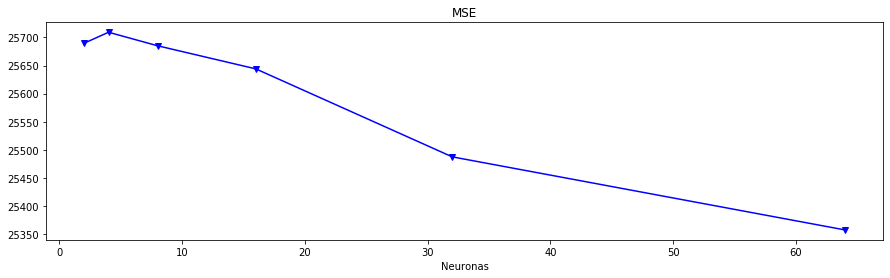

In [288]:
plt.figure(figsize=(15,4))
plt.xlabel('Neuronas')
plt.title("MSE")
plt.plot(NeuronasCapa, Historial, 'bv-')

In [289]:
Capas = [[64],[64,64],[64,64,64],[64,64,64,64],[64,64,64,64,64]]
HistorialCapas = []
for i in Capas:
    HistorialModeloPredCapas = []
    ModeloCapas = tf.estimator.DNNRegressor(hidden_units=i, feature_columns=FeatureColumns)
    ModeloCapas.train(input_fn=Estimador,steps=5000)
    PrecFuncionCapas = tf.compat.v1.estimator.inputs.pandas_input_fn(x=XTest,batch_size=10,num_epochs=1,shuffle=False)
    ModeloPredCapas = ModeloCapas.predict(PrecFuncionCapas)

    for x in list(ModeloPredCapas):
        HistorialModeloPredCapas.append(x['predictions'])
    HistorialCapas.append(mean_squared_error(HistorialModeloPredCapas,YTest))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\HOME\\AppData\\Local\\Temp\\tmpeekhqik8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, yo

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\HOME\\AppData\\Local\\Temp\\tmpyd8orx23', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If i

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\HOME\AppData\Local\Temp\tmp3_o_w9sv\model.ckpt.
INFO:tensorflow:loss = 35839.254, step = 0
INFO:tensorflow:global_step/sec: 191.194
INFO:tensorflow:loss = 19217.068, step = 100 (0.522 sec)
INFO:tensorflow:global_step

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\HOME\AppData\Local\Temp\tmpi8jvyjyi\model.ckpt.
INFO:tensorflow:loss = 26448.754, step = 0
INFO:tensorflow:global_step/sec: 199.589
INFO:tensorflow:loss = 23562.223, step = 100 (0.501 sec)
INFO:tensorflow:global_step/sec: 249.986
INFO:tensorflow:loss = 31532.475, step = 200 (0.400 sec)
INFO:tensorflow:global_step/sec: 250.612
INFO:tensorflow:loss = 25853.611, step = 300 (0.399 sec)
INFO:tensorflow:global_step/sec: 249.362
INFO:tensorflow:loss = 17678.16, step = 400 (0.400 sec)
INFO:tensorflow:global_step/sec: 259.053
INFO:tensorflow:loss = 21812.588, step = 500 (0.387 sec)
INFO:tensorflow:global_step/sec: 229.345
INFO:tensorflow:loss = 18917.516, step = 600 (0.436 sec)
INFO:tensorflow:global_step/sec: 228.82
INFO:tensorflow:loss = 1

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\HOME\AppData\Local\Temp\tmpben2g7ff\model.ckpt.
INFO:tensorflow:loss = 18647.613, step = 0
INFO:tensorflow:global_step/sec: 194.921
INFO:tensorflow:loss = 32071.871, step = 100 (0.514 sec)
INFO:tensorflow:global_step/sec: 249.986
INFO:tensorflow:loss = 20828.17, step = 200 (0.399 sec)
INFO:tensorflow:global_step/sec: 251.242
INFO:tensorflow:loss = 14195.1875, step = 300 (0.397 sec)
INFO:tensorflow:global_step/sec: 251.242
INFO:tensorflow:loss = 23060.861, step = 400 (0.398 sec)
INFO:tensorflow:global_step/sec: 254.438
INFO:tensorflow:loss = 12162.544, step = 500 (0.393 sec)
INFO:tensorflow:global_step/sec: 235.281
INFO:tensorflow:loss = 5232.6025, step = 600 (0.424 sec)
INFO:tensorflow:global_step/sec: 218.328
INFO:tensorflow:loss = 6485.884, step = 700 (0.460 sec)
INFO:tensorflow:global_step/sec: 240.371
INFO:tensorflow:loss = 2008.4606, step = 800 

[25306.24441271177, 17934.24348444601, 4256.704749882071, 3699.1114466467525, 3158.1201085353464]


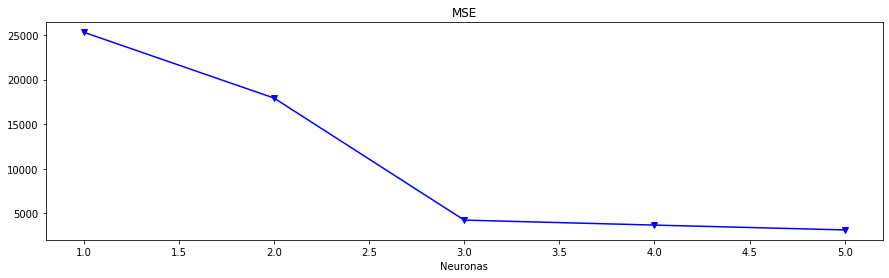

In [291]:
plt.figure(figsize=(15,4))
plt.xlabel('Neuronas')
plt.title("MSE")
plt.plot([1,2,3,4,5], HistorialCapas, 'bv-')

In [296]:
Final =[]
ModeloFinal = tf.estimator.DNNRegressor(hidden_units=[64,64,64,64,64], feature_columns=FeatureColumns)
ModeloFinal.train(input_fn=Estimador,steps=5000)
PrecFuncionFinal = tf.compat.v1.estimator.inputs.pandas_input_fn(x=XTest,batch_size=10,num_epochs=1,shuffle=False)
ModeloPredFinal = ModeloFinal.predict(PrecFuncionFinal)
for x in list(ModeloPredFinal):
        Final.append(x['predictions'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\HOME\\AppData\\Local\\Temp\\tmp_eqay7y3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, yo

3299.1111548346353


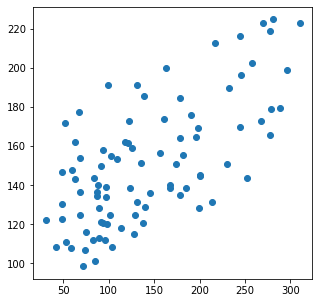

In [306]:
plt.figure(figsize=(5,5))
plt.scatter(YTest,Final)
print(mean_squared_error(YTest, Final))

In [324]:
def validacion(Indice, IndiceTest, Variables, Resultados):
    Xent = Variables.iloc[Indice,:]
    Xtest = Variables.iloc[IndiceTest,:]
    Yent = Resultados.iloc[Indice]
    Ytest = Resultados.iloc[IndiceTest]
    Xent.columns = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
    Xtest.columns = Xent.columns.copy()

    bmi = tf.feature_column.numeric_column('bmi')
    s5 = tf.feature_column.numeric_column('s5')
    bp = tf.feature_column.numeric_column('bp')
    FeatureColumns = [bmi,s5,bp]
    
    Estimador = tf.compat.v1.estimator.inputs.pandas_input_fn(x=Xent,y=Yent,batch_size=10,num_epochs=3000,shuffle=True)
    Final = []
    
    ModeloFinal = tf.estimator.DNNRegressor(hidden_units=[64,64,64,64,64], feature_columns=FeatureColumns)
    ModeloFinal.train(input_fn=Estimador,steps=5000)
    PrecFuncionFinal = tf.compat.v1.estimator.inputs.pandas_input_fn(x=Xtest,batch_size=10,num_epochs=1,shuffle=False)
    ModeloPredFinal = ModeloFinal.predict(PrecFuncionFinal)
    for x in list(ModeloPredFinal):
            Final.append(x['predictions'])
            
    return metrics.mean_squared_error(Ytest, Final)

In [326]:
ResultadoFinal = []
kf = KFold(n_splits=4)

for Ent, Test in kf.split(Variables):   
    ResultadoFinal.append(validacion(Ent,Test,Variables,Resultados))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\HOME\\AppData\\Local\\Temp\\tmpih6pnf6g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, yo

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\HOME\\AppData\\Local\\Temp\\tmpczg6isr5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If i

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\HOME\AppData\Local\Temp\tmprb6a6gka\model.ckpt.
INFO:tensorflow:loss = 38749.305, step = 0
INFO:tensorflow:global_step/sec: 167.495
INFO:tensorflow:loss = 20282.143, step = 100 (0.597 sec)
INFO:tensorflow:global_step

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\HOME\AppData\Local\Temp\tmpvmwg1_fh\model.ckpt.
INFO:tensorflow:loss = 28242.129, step = 0
INFO:tensorflow:global_step/sec: 138.114
INFO:tensorflow:loss = 20224.197, step = 100 (0.724 sec)
INFO:tensorflow:global_step/sec: 202.418
INFO:tensorflow:loss = 33286.484, step = 200 (0.492 sec)
INFO:tensorflow:global_step/sec: 213.663
INFO:tensorflow:loss = 13332.638, step = 300 (0.469 sec)
INFO:tensorflow:global_step/sec: 204.906
INFO:tensorflow:loss = 12833.002, step = 400 (0.491 sec)
INFO:tensorflow:global_step/sec: 208.322
INFO:tensorflow:loss = 7607.1187, step = 500 (0.476 sec)
INFO:tensorflow:global_step/sec: 190.829
INFO:tensorflow:loss = 9361.85, step = 600 (0.526 sec)
INFO:tensorflow:global_step/sec: 160.247
INFO:tensorflow:loss = 6

In [328]:
print(np.array(ResultadoFinal).sum()/len(ResultadoFinal))

3405.8588271791214
